In [19]:
import pandas as pd
df = pd.read_pickle('df_for_model.pkl')
df = df.drop(columns = "Unnamed: 0")

In [20]:
df

,날짜,Ave_sentiment,본문,industry,종가(백만원),거래량(천주),전일대비,Total_News,Total_Volume,Risk_Index,D+1 종가,D+2 종가,D+1 상승률,D+2 상승률,article_ratio,trade_volum_ratio
0,2025-10-01,0.696901,84,건설,773.53,6922801,5.47,437,30751473,0.024878,774.52,788.26,0.127985,1.904257,0.192220,0.225121
1,2025-10-02,0.669425,40,건설,774.52,7349337,0.99,280,35183514,0.016957,788.26,786.46,1.774002,1.541600,0.142857,0.208886
2,2025-10-10,0.580599,30,건설,788.26,11288559,13.74,179,47060285,0.019343,786.46,788.96,-0.228351,0.088803,0.167598,0.239874
3,2025-10-13,0.573305,50,건설,786.46,8443590,-1.80,323,34617515,0.018009,788.96,822.37,0.317880,4.566030,0.154799,0.243911
4,2025-10-14,0.525187,71,건설,788.96,36232856,2.50,328,67871370,0.044022,822.37,813.93,4.234689,3.164926,0.216463,0.533846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2025-12-15,0.803046,206,헬스케어,4927.73,30104286,62.48,477,144788403,0.054455,4881.50,4796.50,-0.938160,-2.663092,0.431866,0.207919
155,2025-12-16,0.798630,274,헬스케어,4881.50,38287102,-46.23,671,139052143,0.066511,4796.50,4775.98,-1.741268,-2.161631,0.408346,0.275343
156,2025-12-17,0.783878,241,헬스케어,4796.50,25323016,-85.00,605,101148584,0.058723,4775.98,4861.55,-0.427812,1.356197,0.398347,0.250355
157,2025-12-18,0.856880,292,헬스케어,4775.98,21146956,-20.52,707,91788855,0.061420,4861.55,NaN,1.791674,NaN,0.413013,0.230387


# 회귀분석

In [81]:
# 데이터 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# [1] 데이터 정리 및 결측치 제거
df_reg = df.dropna(subset=['D+1 종가', 'D+2 종가']).copy()

# [2] 학습 변수(X) 및 타겟(y) 설정
features = [
    'Ave_sentiment', '본문', '종가(백만원)', '거래량(천주)', '전일대비', 
    'Total_News', 'Total_Volume', 'Risk_Index', 
    'article_ratio', 'trade_volum_ratio'
]

X = df_reg[features].values
y = df_reg[['D+1 종가', 'D+2 종가']].values

# [3] 데이터 정규화 (X와 y를 각각 다른 스케일러로 학습)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# [4] 시계열 분할 (순서 유지)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

print(f" 전처리 완료 (MinMaxScaler 적용)")
print(f" X_train 모양: {X_train.shape}, y_train 모양: {y_train.shape}")
print(f" 주가 범위(Scaled): {y_train.min()} ~ {y_train.max()} (0~1 사이로 압축됨)")

 전처리 완료 (MinMaxScaler 적용)
 X_train 모양: (122, 10), y_train 모양: (122, 2)
 주가 범위(Scaled): 0.0 ~ 0.9422349503214495 (0~1 사이로 압축됨)


In [82]:
# 모델(전체 산업) 구축 -- 단위 원화라서 숫자가 커보임

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

model_reg = Sequential([
    Input(shape=(len(features),)),
    Dense(128, activation='relu'),
    Dropout(0.1), # 과적합을 방지.
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2) # 출력: D+1 가격, D+2 가격
])

model_reg.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n 수정된 데이터로 회귀 분석 학습 시작...")
# 시각적으로 학습 과정을 확인하기 위해 validation_data를 넣습니다.
history = model_reg.fit(
    X_train, y_train, 
    epochs=500, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=1
)


 수정된 데이터로 회귀 분석 학습 시작...
Epoch 1/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0837 - mae: 0.1982 - val_loss: 0.2066 - val_mae: 0.4502
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0448 - mae: 0.1810 - val_loss: 0.1261 - val_mae: 0.3511
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - mae: 0.1254 - val_loss: 0.1206 - val_mae: 0.3414
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - mae: 0.0902 - val_loss: 0.0404 - val_mae: 0.1817
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - mae: 0.0868 - val_loss: 0.0262 - val_mae: 0.1353
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0091 - mae: 0.0675 - val_loss: 0.0128 - val_mae: 0.0873
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0097 - mae: 0.0755 - val_loss: 0.0111 - val_mae: 0.0874
Epoch 8/500
8/8 [==============================] - 0s 7ms/step - loss:

Epoch 64/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0245 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 65/500
8/8 [==============================] - 0s 5ms/step - loss: 8.6950e-04 - mae: 0.0218 - val_loss: 0.0030 - val_mae: 0.0464
Epoch 66/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0014 - val_mae: 0.0301
Epoch 67/500
8/8 [==============================] - 0s 5ms/step - loss: 9.6917e-04 - mae: 0.0225 - val_loss: 0.0034 - val_mae: 0.0480
Epoch 68/500
8/8 [==============================] - 0s 5ms/step - loss: 8.5596e-04 - mae: 0.0218 - val_loss: 0.0019 - val_mae: 0.0341
Epoch 69/500
8/8 [==============================] - 0s 4ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 0.0013 - val_mae: 0.0286
Epoch 70/500
8/8 [==============================] - 0s 5ms/step - loss: 9.7072e-04 - mae: 0.0210 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 71/500
8/8 [==============================] - 0s 6ms/step - loss: 9.

8/8 [==============================] - 0s 6ms/step - loss: 7.1855e-04 - mae: 0.0190 - val_loss: 0.0022 - val_mae: 0.0388
Epoch 126/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0012 - mae: 0.0232 - val_loss: 0.0030 - val_mae: 0.0440
Epoch 127/500
8/8 [==============================] - 0s 5ms/step - loss: 8.1991e-04 - mae: 0.0202 - val_loss: 0.0027 - val_mae: 0.0412
Epoch 128/500
8/8 [==============================] - 0s 5ms/step - loss: 7.7395e-04 - mae: 0.0206 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 129/500
8/8 [==============================] - 0s 5ms/step - loss: 7.6318e-04 - mae: 0.0193 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 130/500
8/8 [==============================] - 0s 5ms/step - loss: 5.3954e-04 - mae: 0.0171 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 131/500
8/8 [==============================] - 0s 5ms/step - loss: 5.1519e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0297
Epoch 132/500
8/8 [==============================] - 0s 5ms/step - loss: 

Epoch 186/500
8/8 [==============================] - 0s 5ms/step - loss: 6.0404e-04 - mae: 0.0154 - val_loss: 0.0021 - val_mae: 0.0350
Epoch 187/500
8/8 [==============================] - 0s 5ms/step - loss: 4.1806e-04 - mae: 0.0143 - val_loss: 0.0020 - val_mae: 0.0339
Epoch 188/500
8/8 [==============================] - 0s 5ms/step - loss: 4.3193e-04 - mae: 0.0148 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 189/500
8/8 [==============================] - 0s 5ms/step - loss: 4.3953e-04 - mae: 0.0149 - val_loss: 0.0047 - val_mae: 0.0601
Epoch 190/500
8/8 [==============================] - 0s 5ms/step - loss: 3.7688e-04 - mae: 0.0139 - val_loss: 0.0018 - val_mae: 0.0329
Epoch 191/500
8/8 [==============================] - 0s 5ms/step - loss: 3.8770e-04 - mae: 0.0137 - val_loss: 0.0019 - val_mae: 0.0331
Epoch 192/500
8/8 [==============================] - 0s 5ms/step - loss: 4.1262e-04 - mae: 0.0134 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 193/500
8/8 [==============================] - 0s

8/8 [==============================] - 0s 5ms/step - loss: 2.9897e-04 - mae: 0.0119 - val_loss: 0.0032 - val_mae: 0.0461
Epoch 247/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4525e-04 - mae: 0.0111 - val_loss: 0.0018 - val_mae: 0.0329
Epoch 248/500
8/8 [==============================] - 0s 5ms/step - loss: 3.9545e-04 - mae: 0.0138 - val_loss: 0.0026 - val_mae: 0.0420
Epoch 249/500
8/8 [==============================] - 0s 5ms/step - loss: 2.3704e-04 - mae: 0.0109 - val_loss: 0.0040 - val_mae: 0.0545
Epoch 250/500
8/8 [==============================] - 0s 5ms/step - loss: 4.9084e-04 - mae: 0.0134 - val_loss: 0.0039 - val_mae: 0.0543
Epoch 251/500
8/8 [==============================] - 0s 5ms/step - loss: 2.7581e-04 - mae: 0.0118 - val_loss: 0.0026 - val_mae: 0.0422
Epoch 252/500
8/8 [==============================] - 0s 5ms/step - loss: 2.7577e-04 - mae: 0.0119 - val_loss: 0.0031 - val_mae: 0.0475
Epoch 253/500
8/8 [==============================] - 0s 5ms/step - lo

Epoch 307/500
8/8 [==============================] - 0s 5ms/step - loss: 2.3364e-04 - mae: 0.0110 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 308/500
8/8 [==============================] - 0s 5ms/step - loss: 4.3225e-04 - mae: 0.0142 - val_loss: 0.0030 - val_mae: 0.0474
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 3.7876e-04 - mae: 0.0135 - val_loss: 0.0083 - val_mae: 0.0866
Epoch 310/500
8/8 [==============================] - 0s 5ms/step - loss: 4.2680e-04 - mae: 0.0129 - val_loss: 0.0026 - val_mae: 0.0441
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9556e-04 - mae: 0.0102 - val_loss: 0.0034 - val_mae: 0.0504
Epoch 312/500
8/8 [==============================] - 0s 5ms/step - loss: 2.2354e-04 - mae: 0.0101 - val_loss: 0.0026 - val_mae: 0.0430
Epoch 313/500
8/8 [==============================] - 0s 5ms/step - loss: 3.8127e-04 - mae: 0.0133 - val_loss: 0.0070 - val_mae: 0.0774
Epoch 314/500
8/8 [==============================] - 0s

8/8 [==============================] - 0s 5ms/step - loss: 2.0992e-04 - mae: 0.0103 - val_loss: 0.0044 - val_mae: 0.0590
Epoch 368/500
8/8 [==============================] - 0s 5ms/step - loss: 1.9855e-04 - mae: 0.0096 - val_loss: 0.0029 - val_mae: 0.0463
Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2572e-04 - mae: 0.0103 - val_loss: 0.0052 - val_mae: 0.0651
Epoch 370/500
8/8 [==============================] - 0s 5ms/step - loss: 1.8445e-04 - mae: 0.0097 - val_loss: 0.0044 - val_mae: 0.0592
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2481e-04 - mae: 0.0103 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 372/500
8/8 [==============================] - 0s 5ms/step - loss: 1.6146e-04 - mae: 0.0090 - val_loss: 0.0045 - val_mae: 0.0594
Epoch 373/500
8/8 [==============================] - 0s 5ms/step - loss: 2.1693e-04 - mae: 0.0098 - val_loss: 0.0043 - val_mae: 0.0581
Epoch 374/500
8/8 [==============================] - 0s 5ms/step - lo

Epoch 428/500
8/8 [==============================] - 0s 5ms/step - loss: 1.8660e-04 - mae: 0.0091 - val_loss: 0.0024 - val_mae: 0.0420
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2475e-04 - mae: 0.0115 - val_loss: 0.0055 - val_mae: 0.0678
Epoch 430/500
8/8 [==============================] - 0s 5ms/step - loss: 3.1808e-04 - mae: 0.0117 - val_loss: 0.0106 - val_mae: 0.0985
Epoch 431/500
8/8 [==============================] - 0s 5ms/step - loss: 3.9446e-04 - mae: 0.0137 - val_loss: 0.0023 - val_mae: 0.0399
Epoch 432/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1305e-04 - mae: 0.0123 - val_loss: 0.0023 - val_mae: 0.0397
Epoch 433/500
8/8 [==============================] - 0s 5ms/step - loss: 2.9386e-04 - mae: 0.0114 - val_loss: 0.0062 - val_mae: 0.0724
Epoch 434/500
8/8 [==============================] - 0s 5ms/step - loss: 2.0589e-04 - mae: 0.0099 - val_loss: 0.0059 - val_mae: 0.0709
Epoch 435/500
8/8 [==============================] - 0s

8/8 [==============================] - 0s 5ms/step - loss: 1.3749e-04 - mae: 0.0081 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 489/500
8/8 [==============================] - 0s 5ms/step - loss: 1.3072e-04 - mae: 0.0082 - val_loss: 0.0104 - val_mae: 0.0980
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4022e-04 - mae: 0.0102 - val_loss: 0.0029 - val_mae: 0.0461
Epoch 491/500
8/8 [==============================] - 0s 5ms/step - loss: 2.2684e-04 - mae: 0.0106 - val_loss: 0.0043 - val_mae: 0.0573
Epoch 492/500
8/8 [==============================] - 0s 5ms/step - loss: 1.7109e-04 - mae: 0.0089 - val_loss: 0.0050 - val_mae: 0.0635
Epoch 493/500
8/8 [==============================] - 0s 5ms/step - loss: 2.2849e-04 - mae: 0.0097 - val_loss: 0.0037 - val_mae: 0.0531
Epoch 494/500
8/8 [==============================] - 0s 4ms/step - loss: 2.0301e-04 - mae: 0.0099 - val_loss: 0.0063 - val_mae: 0.0734
Epoch 495/500
8/8 [==============================] - 0s 5ms/step - lo

In [83]:
def test_regression_model_final(row_index):
    # 1. 테스트 데이터 추출
    input_data = X_test[row_index].reshape(1, -1)
    actual_val = y_test[row_index] # 단위: 백만원
    
    # 2. 모델 예측
    prediction = model_reg.predict(input_data, verbose=0)[0]
    
    # 3. 결과 출력
    print(f"--- [Index {row_index}] 실전 예측 리포트 (단위: 원) ---")
    print(f" 실제 가격: D+1 [{actual_val[0]*1e6:,.0f}원], D+2 [{actual_val[1]*1e6:,.0f}원]")
    print(f" 예측 가격: D+1 [{prediction[0]*1e6:,.0f}원], D+2 [{prediction[1]*1e6:,.0f}원]")
    
    # 오차 계산
    diff_d1_m = abs(actual_val[0] - prediction[0])
    print(f" D+1 오차금액: {diff_d1_m*1e6:,.0f}원")
    print(f" 오차율: {diff_d1_m / actual_val[0] * 100:.2f}%")
    print("-" * 50)

# 상위 5개 샘플 테스트
for i in range(5):
    test_regression_model_final(i)

--- [Index 0] 실전 예측 리포트 (단위: 원) ---
 실제 가격: D+1 [921,870원], D+2 [908,175원]
 예측 가격: D+1 [919,748원], D+2 [915,617원]
 D+1 오차금액: 2,122원
 오차율: 0.23%
--------------------------------------------------
--- [Index 1] 실전 예측 리포트 (단위: 원) ---
 실제 가격: D+1 [908,175원], D+2 [908,853원]
 예측 가격: D+1 [917,341원], D+2 [920,994원]
 D+1 오차금액: 9,166원
 오차율: 1.01%
--------------------------------------------------
--- [Index 2] 실전 예측 리포트 (단위: 원) ---
 실제 가격: D+1 [908,853원], D+2 [897,110원]
 예측 가격: D+1 [899,903원], D+2 [918,460원]
 D+1 오차금액: 8,950원
 오차율: 0.98%
--------------------------------------------------
--- [Index 3] 실전 예측 리포트 (단위: 원) ---
 실제 가격: D+1 [897,110원], D+2 [959,794원]
 예측 가격: D+1 [874,498원], D+2 [868,400원]
 D+1 오차금액: 22,613원
 오차율: 2.52%
--------------------------------------------------
--- [Index 4] 실전 예측 리포트 (단위: 원) ---
 실제 가격: D+1 [959,794원], D+2 [993,477원]
 예측 가격: D+1 [893,793원], D+2 [903,507원]
 D+1 오차금액: 66,002원
 오차율: 6.88%
--------------------------------------------------


In [84]:
import os
from sklearn.metrics import mean_absolute_error, r2_score

# 1. 모델 예측 및 복원 (지표 계산용)
y_pred_scaled = model_reg.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# 2. 핵심 지표 산출
# D+1 가격 기준 오차와 전체 결정계수(R2) 계산
mae_val = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_val = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
final_loss = history.history['loss'][-1]

# 3. 파일명 생성
filename = f"모든산업_회귀_MAE_{mae_val:.2f}_신뢰도(R2)_{r2_val:.4f}_Loss_{final_loss:.6f}.h5"

# 4. 모델 저장
model_reg.save(filename)

print("-" * 50)
print(f" 모델 저장 완료: {filename}")
print(f" 최종 MAE: {mae_val:.2f} 원")
print(f" 최종 신뢰도(R2): {r2_val:.4f}")
print(f" 최종 Loss: {final_loss:.6f}")
print("-" * 50)

1/1 [==============================] - 0s 10ms/step
--------------------------------------------------
 모델 저장 완료: 모든산업_회귀_MAE_174.80_신뢰도(R2)_-1.9763_Loss_0.000153.h5
 최종 MAE: 174.80 원
 최종 신뢰도(R2): -1.9763
 최종 Loss: 0.000153
--------------------------------------------------


In [85]:
# 모델(산업별) 구축 -- 원핫인코딩

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# [4] 정규화 및 분할 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 1. 입력용(X) 스케일러와 출력용(y) 스케일러 분리
scaler_X = StandardScaler()
scaler_y = MinMaxScaler() 

# 2. X와 y 각각 정규화 진행
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  # y(주가)를 0~1 사이 값

# 3. 데이터 분할 (y 대신 y_scaled를 사용함)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

print(f" 추가된 산업 카테고리: {industry_cols}")
print(f" 총 피처 수: {len(features)}개")
print(f" 타겟 정규화 완료 (y_train 범위: {y_train.min():.2f} ~ {y_train.max():.2f})")

 추가된 산업 카테고리: ['ind_건설', 'ind_자동차', 'ind_헬스케어']
 총 피처 수: 10개
 타겟 정규화 완료 (y_train 범위: 0.00 ~ 0.94)


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam


model_reg_v2 = Sequential([
    Input(shape=(len(features),)),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)
])

model_reg_v2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\n 산업별(One-Hot) 반영 모델 학습")
history = model_reg_v2.fit(
    X_train, y_train, 
    epochs=500, 
    batch_size=16, 
    validation_data=(X_test, y_test),
    verbose=0 
)
print(" 학습 완료!")


 산업별(One-Hot) 반영 모델 학습
 학습 완료!


1/1 [==============================] - 0s 26ms/step


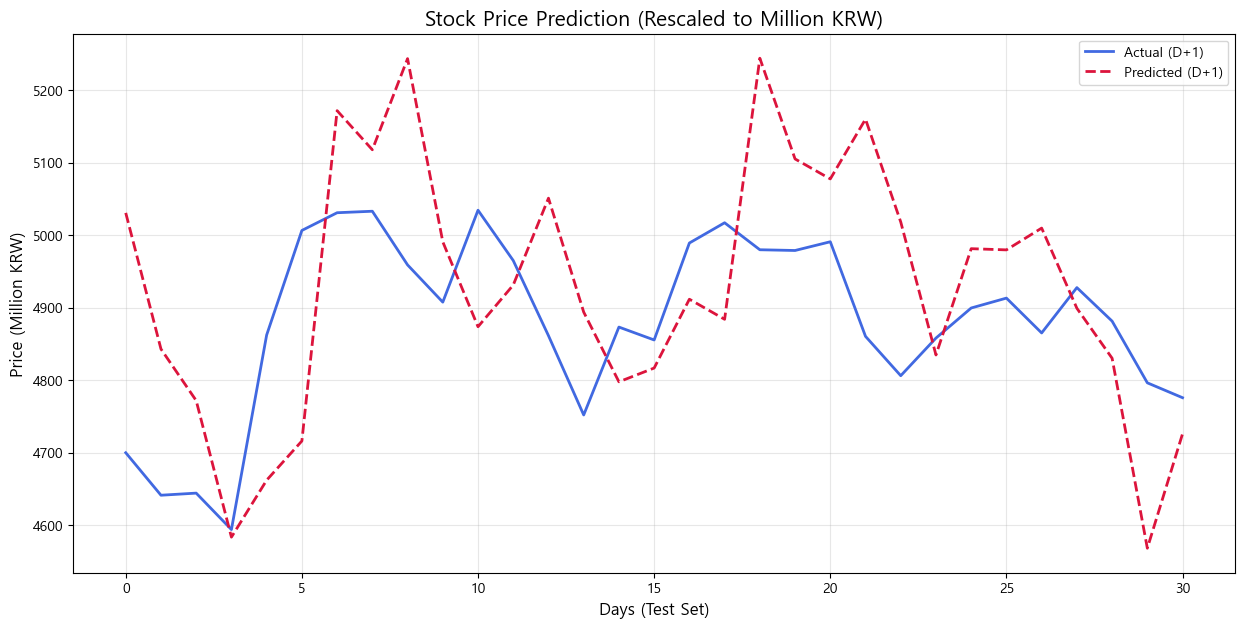

 실제 단위 복원 후 평균 오차(MAE): 160.24 (백만원)
 최종 R2 Score: -1.8933


In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# [1] 모델 예측 0~1 사이 정규화
y_pred_scaled = model_reg_v2.predict(X_test)

# [2] 중요: 원래 단위(백만 원)로 복원 (Inverse Transform)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# [3] 시각화 
plt.figure(figsize=(15, 7))

# D+1 예측값 vs 실제값 
plt.plot(y_test_rescaled[:, 0], label='Actual (D+1)', color='royalblue', linewidth=2)
plt.plot(y_pred_rescaled[:, 0], label='Predicted (D+1)', color='crimson', linestyle='--', linewidth=2)

plt.title('Stock Price Prediction (Rescaled to Million KRW)', fontsize=15)
plt.xlabel('Days (Test Set)', fontsize=12)
plt.ylabel('Price (Million KRW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# [4] 최종 지표 확인
final_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
final_r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f" 실제 단위 복원 후 평균 오차(MAE): {final_mae:.2f} (백만원)")
print(f" 최종 R2 Score: {final_r2:.4f}")

# 분류분석

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# [1] 데이터 정리 및 결측치 제거
df_reg = df.dropna(subset=['D+1 종가']).copy()

# [2] 학습 변수(X) 및 타겟(y) 설정
features = [
    'Ave_sentiment', '본문', '종가(백만원)', '거래량(천주)', '전일대비', 
    'Total_News', 'Total_Volume', 'Risk_Index', 
    'article_ratio', 'trade_volum_ratio'
]

X = df_reg[features].values

# [3] 분류용 라벨링 (Target 생성)
# 내일(D+1) 종가가 오늘 종가보다 높으면 1(상승), 낮거나 같으면 0(하락/보합)
y_class = (df_reg['D+1 종가'] > df_reg['종가(백만원)']).astype(int).values

# [4] 데이터 정규화
# X를 0~1 사이로 압축.
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


# [5] 시계열 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_class, test_size=0.2, shuffle=False
)

print("-" * 50)
print(f" 전처리 완료 (분류 분석 모드)")
print(f" 학습 데이터: {X_train.shape[0]}개 / 테스트 데이터: {X_test.shape[0]}개")
print(f" 상승 데이터 비율 (Train): {np.mean(y_train)*100:.2f}%")
print(f" 하락/보합 데이터 비율 (Train): {(1-np.mean(y_train))*100:.2f}%")
print("-" * 50)

--------------------------------------------------
 전처리 완료 (분류 분석 모드)
 학습 데이터: 124개 / 테스트 데이터: 32개
 상승 데이터 비율 (Train): 55.65%
 하락/보합 데이터 비율 (Train): 44.35%
--------------------------------------------------


In [89]:
# #과적합으로 인한 모델 폐기
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras.optimizers import Adam

# # [1] 분류 모델 설계
# model_class = Sequential([
#     Input(shape=(len(features),)),
#     Dense(128, activation='relu'),
#     Dropout(0.3), # 과적합 방지 
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid') # 이진 분류 핵심: 0~1 사이 확률 출력
# ])

# # [2] 분류용 손실함수(binary_crossentropy) 사용
# model_class.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy', 
#     metrics=['accuracy']
# )

# # [3] 모델 학습
# print("\n 방향성(상승/하락) 예측 모델 학습")
# history_class = model_class.fit(
#     X_train, y_train,
#     epochs=300,
#     batch_size=16,
#     validation_data=(X_test, y_test),
#     verbose=1
# 

In [90]:
from tensorflow.keras.optimizers import RMSprop

model_class_v3 = Sequential([
    Input(shape=(len(features),)),
    Dense(64, activation='relu'), # 32에서 다시 64로 확장
    Dropout(0.3),                 # 0.5에서 0.3으로 완화
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 학습률 0.001, RMSprop을 사용
model_class_v3.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history_class_v3 = model_class_v3.fit(
    X_train, y_train,
    epochs=200, 
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6985 - accuracy: 0.5565 - val_loss: 0.7149 - val_accuracy: 0.4688
Epoch 2/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5565 - val_loss: 0.7113 - val_accuracy: 0.4688
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5565 - val_loss: 0.7095 - val_accuracy: 0.4688
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5565 - val_loss: 0.7059 - val_accuracy: 0.4688
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5565 - val_loss: 0.7048 - val_accuracy: 0.4688
Epoch 6/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5565 - val_loss: 0.7043 - val_accuracy: 0.4688
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5645 - val_loss: 0.7043 - val_accuracy: 0.4688
Epoch 8/200
8/8 [=========

8/8 [==============================] - 0s 5ms/step - loss: 0.6546 - accuracy: 0.5645 - val_loss: 0.6883 - val_accuracy: 0.6562
Epoch 60/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6129 - val_loss: 0.6886 - val_accuracy: 0.6562
Epoch 61/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6464 - accuracy: 0.6290 - val_loss: 0.6878 - val_accuracy: 0.6250
Epoch 62/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6355 - accuracy: 0.6290 - val_loss: 0.6898 - val_accuracy: 0.6562
Epoch 63/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6424 - accuracy: 0.5726 - val_loss: 0.6917 - val_accuracy: 0.5938
Epoch 64/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6210 - val_loss: 0.6933 - val_accuracy: 0.5625
Epoch 65/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6129 - val_loss: 0.6926 - val_accuracy: 0.6250
Epoch 66/200
8/8 [===============

8/8 [==============================] - 0s 5ms/step - loss: 0.6029 - accuracy: 0.6855 - val_loss: 0.7037 - val_accuracy: 0.5312
Epoch 118/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5887 - accuracy: 0.6694 - val_loss: 0.7043 - val_accuracy: 0.5312
Epoch 119/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5931 - accuracy: 0.6935 - val_loss: 0.7031 - val_accuracy: 0.5625
Epoch 120/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6133 - accuracy: 0.6290 - val_loss: 0.7031 - val_accuracy: 0.5312
Epoch 121/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5953 - accuracy: 0.6774 - val_loss: 0.7085 - val_accuracy: 0.5312
Epoch 122/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5872 - accuracy: 0.6935 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 123/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5781 - accuracy: 0.6855 - val_loss: 0.7051 - val_accuracy: 0.5625
Epoch 124/200
8/8 [========

8/8 [==============================] - 0s 5ms/step - loss: 0.5549 - accuracy: 0.7177 - val_loss: 0.7278 - val_accuracy: 0.5312
Epoch 176/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5342 - accuracy: 0.7177 - val_loss: 0.7320 - val_accuracy: 0.5625
Epoch 177/200
8/8 [==============================] - 0s 6ms/step - loss: 0.5542 - accuracy: 0.7097 - val_loss: 0.7333 - val_accuracy: 0.5938
Epoch 178/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5602 - accuracy: 0.6774 - val_loss: 0.7297 - val_accuracy: 0.5312
Epoch 179/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5315 - accuracy: 0.7339 - val_loss: 0.7318 - val_accuracy: 0.5625
Epoch 180/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5419 - accuracy: 0.7097 - val_loss: 0.7243 - val_accuracy: 0.5312
Epoch 181/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5262 - accuracy: 0.7903 - val_loss: 0.7215 - val_accuracy: 0.6250
Epoch 182/200
8/8 [========

## gemini 추천방식

In [91]:
# 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GaussianNoise
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# [1] 데이터 정리 및 상호작용 피처 생성
df_reg = df.dropna(subset=['D+1 종가']).copy()

# Risk 지수 강화 피처 (이 부분이 핵심입니다)
df_reg['Risk_Sentiment_Impact'] = df_reg['Risk_Index'] * (1 - df_reg['Ave_sentiment'])
df_reg['Risk_Volume_Impact'] = df_reg['Risk_Index'] * df_reg['trade_volum_ratio']

# [2] 학습 변수(X) 설정
features = [
    'Ave_sentiment', '종가(백만원)', '거래량(천주)', '전일대비', 
    'Total_News', 'Total_Volume', 'Risk_Index', 
    'article_ratio', 'trade_volum_ratio',
    'Risk_Sentiment_Impact', 'Risk_Volume_Impact' # 추가된 리스크 강화 피처
]

X = df_reg[features].values
# 타겟(y): 내일 상승(1), 하락/보합(0)
y_class = (df_reg['D+1 종가'] > df_reg['종가(백만원)']).astype(int).values

# [3] 데이터 정규화 및 분할
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_class, test_size=0.2, shuffle=False
)

# [4] 모델 설계
model_risk_focused = Sequential([
    Input(shape=(len(features),)),
    GaussianNoise(0.05),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_risk_focused.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# [5] 학습 진행
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

print(f"🚀 Risk 강화 모델 학습 시작 (피처 수: {len(features)}개)...")
history = model_risk_focused.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# [6] 최종 결과 출력
loss, acc = model_risk_focused.evaluate(X_test, y_test, verbose=0)
print(f"\n[최종 성적표] 검증 데이터 정확도: {acc*100:.2f}%")

🚀 Risk 강화 모델 학습 시작 (피처 수: 11개)...
Epoch 1/300
8/8 [==============================] - 0s 12ms/step - loss: 0.6909 - accuracy: 0.5242 - val_loss: 0.7015 - val_accuracy: 0.4688
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5806 - val_loss: 0.7034 - val_accuracy: 0.4688
Epoch 3/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5726 - val_loss: 0.7054 - val_accuracy: 0.4688
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6806 - accuracy: 0.5565 - val_loss: 0.7049 - val_accuracy: 0.4688
Epoch 5/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6814 - accuracy: 0.5726 - val_loss: 0.7063 - val_accuracy: 0.4688
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.5565 - val_loss: 0.7058 - val_accuracy: 0.4688
Epoch 7/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5645 - val_loss: 0.7065 - val_accuracy:

8/8 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6129 - val_loss: 0.6902 - val_accuracy: 0.6250
Epoch 60/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6628 - accuracy: 0.6048 - val_loss: 0.6883 - val_accuracy: 0.6875
Epoch 61/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6735 - accuracy: 0.5403 - val_loss: 0.6917 - val_accuracy: 0.6250
Epoch 62/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.5565 - val_loss: 0.6909 - val_accuracy: 0.6250
Epoch 63/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6663 - accuracy: 0.5565 - val_loss: 0.6939 - val_accuracy: 0.5938
Epoch 64/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.5565 - val_loss: 0.6919 - val_accuracy: 0.5938
Epoch 65/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.5645 - val_loss: 0.6914 - val_accuracy: 0.5938
Epoch 66/300
8/8 [===============

# 머신러닝 (randomforest

In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# [1] 데이터 정리 및 결측치 제거
df_reg = df.dropna(subset=['D+1 종가']).copy()

# [2] 리스크 지수 고도화 (사용자님의 직관 반영)
# ① 리스크 변화량: 시장은 절대 수치보다 '변화'에 민감함
df_reg['Risk_Incr'] = df_reg['Risk_Index'].diff().fillna(0)

# ② 임계점 리스크: 리스크가 일정 수준(예: 0.7)을 넘을 때만 파급력이 생김
df_reg['Critical_Risk'] = (df_reg['Risk_Index'] > 0.7).astype(int)

# ③ 리스크와 감성/거래량의 상호작용
df_reg['Risk_Sentiment_Impact'] = df_reg['Risk_Index'] * (1 - df_reg['Ave_sentiment'])
df_reg['Risk_Volume_Impact'] = df_reg['Risk_Index'] * df_reg['trade_volum_ratio']

# [3] 학습 변수(X) 설정 (기존 + 신규 리스크 피처)
features = [
    'Ave_sentiment', '종가(백만원)', '거래량(천주)', '전일대비', 
    'Total_News', 'Total_Volume', 'Risk_Index', 
    'article_ratio', 'trade_volum_ratio',
    'Risk_Incr', 'Critical_Risk',             # 신규 추가
    'Risk_Sentiment_Impact', 'Risk_Volume_Impact' # 상호작용
]

X = df_reg[features].values

# [4] 분류용 타겟(y) 생성 (내일 상승 1, 하락/보합 0)
y_class = (df_reg['D+1 종가'] > df_reg['종가(백만원)']).astype(int).values

# [5] 데이터 정규화 및 시계열 분할
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_class, test_size=0.2, shuffle=False
)

print("-" * 50)
print(f" 리스크 강화형 전처리 완료 (총 변수: {len(features)}개)")
print(f" 학습 데이터: {X_train.shape[0]}개 / 테스트 데이터: {X_test.shape[0]}개")
print(f" 새로 추가된 핵심 변수: Risk_Incr, Critical_Risk 등")
print("-" * 50)

--------------------------------------------------
 리스크 강화형 전처리 완료 (총 변수: 13개)
 학습 데이터: 124개 / 테스트 데이터: 32개
 새로 추가된 핵심 변수: Risk_Incr, Critical_Risk 등
--------------------------------------------------


In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GaussianNoise
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# [1] 데이터 정리 및 상호작용 피처 생성
df_reg = df.dropna(subset=['D+1 종가']).copy()

# Risk 지수 강화 
df_reg['Risk_Sentiment_Impact'] = df_reg['Risk_Index'] * (1 - df_reg['Ave_sentiment'])
df_reg['Risk_Volume_Impact'] = df_reg['Risk_Index'] * df_reg['trade_volum_ratio']

# [2] 학습 변수(X) 설정
features = [
    'Ave_sentiment', '종가(백만원)', '거래량(천주)', '전일대비', 
    'Total_News', 'Total_Volume', 'Risk_Index', 
    'article_ratio', 'trade_volum_ratio',
    'Risk_Sentiment_Impact', 'Risk_Volume_Impact' # 추가된 리스크 강화 피처
]

X = df_reg[features].values
# 타겟(y): 내일 상승(1), 하락/보합(0)
y_class = (df_reg['D+1 종가'] > df_reg['종가(백만원)']).astype(int).values

# [3] 데이터 정규화 및 분할
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_class, test_size=0.2, shuffle=False
)

# [4] 모델 
model_risk_focused = Sequential([
    Input(shape=(len(features),)),
    GaussianNoise(0.05), 
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_risk_focused.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# [5] 학습
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

print(f"Risk 강화 모델 학습 시작 (피처 수: {len(features)}개)...")
history = model_risk_focused.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# [6] 최종 결과 출력
loss, acc = model_risk_focused.evaluate(X_test, y_test, verbose=0)
print(f"\n 검증 데이터 정확도: {acc*100:.2f}%")

Risk 강화 모델 학습 시작 (피처 수: 11개)...
Epoch 1/300
8/8 [==============================] - 0s 12ms/step - loss: 0.6991 - accuracy: 0.5484 - val_loss: 0.7066 - val_accuracy: 0.4688
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5323 - val_loss: 0.7030 - val_accuracy: 0.4688
Epoch 3/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.5161 - val_loss: 0.7002 - val_accuracy: 0.4688
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.6210 - val_loss: 0.7031 - val_accuracy: 0.4688
Epoch 5/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5242 - val_loss: 0.7037 - val_accuracy: 0.4688
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5806 - val_loss: 0.7011 - val_accuracy: 0.4688
Epoch 7/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5806 - val_loss: 0.6987 - val_accuracy: 0

8/8 [==============================] - 0s 5ms/step - loss: 0.6671 - accuracy: 0.5645 - val_loss: 0.6838 - val_accuracy: 0.5312
Epoch 60/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6722 - accuracy: 0.5806 - val_loss: 0.6828 - val_accuracy: 0.5000
Epoch 61/300
8/8 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.5565 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 62/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6629 - accuracy: 0.5565 - val_loss: 0.6830 - val_accuracy: 0.5312
Epoch 63/300
8/8 [==============================] - 0s 7ms/step - loss: 0.6547 - accuracy: 0.5806 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 64/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6541 - accuracy: 0.6129 - val_loss: 0.6842 - val_accuracy: 0.5312
Epoch 65/300
8/8 [==============================] - 0s 6ms/step - loss: 0.6445 - accuracy: 0.5968 - val_loss: 0.6827 - val_accuracy: 0.5312
Epoch 66/300
8/8 [===============

📊 Random Forest 검증 정확도: 62.50%


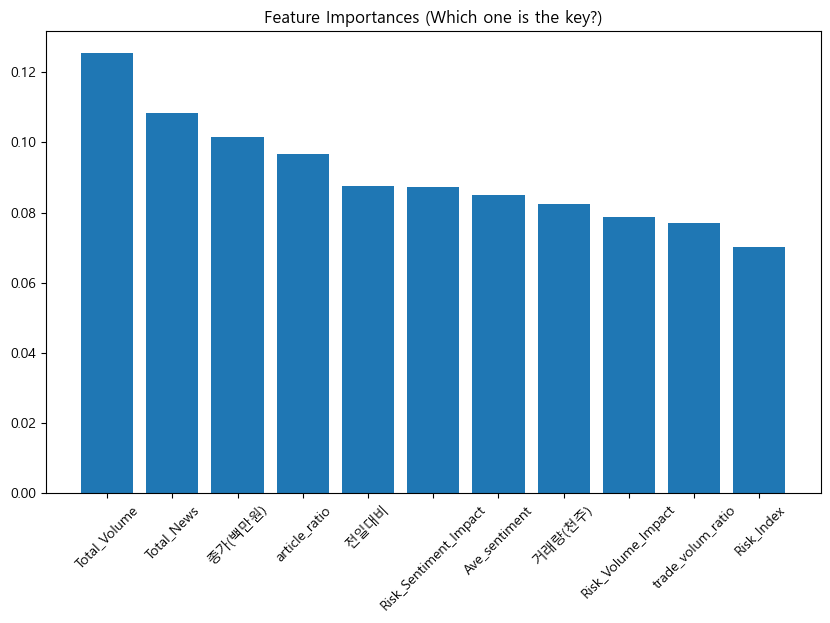

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# [1] 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# [2] 예측 및 정확도 확인
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"📊 Random Forest 검증 정확도: {rf_acc*100:.2f}%")

# [3] 변수 중요도 시각화
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Which one is the key?)")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.show()

In [96]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, log_loss, mean_squared_error
import numpy as np

# 1. 모델 예측 (확률값 포함 - Loss 계산용)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test) # Log Loss를 위해 확률값 필요

# 2. 요청하신 주요 지표 산출
acc = accuracy_score(y_test, rf_pred) * 100       # 정확도 (%)
precision = precision_score(y_test, rf_pred) * 100 # 신뢰도/정밀도 (%)
loss_val = log_loss(y_test, rf_prob)               # 모델의 손실(Log-Loss)
mse = mean_squared_error(y_test, rf_pred)          # 오차(MSE)

# 3. 파일 생성 (특수문자 제거 및 수치 포함)
# 형식: 전체산업회귀분석_Acc62.50_PrecXX.XX_LossX.XX_ErrX.XX.joblib
file_name = f"전체산업회귀분석_Acc{acc:.2f}_Prec{precision:.2f}_Loss{loss_val:.2f}_Err{mse:.2f}.joblib"

# 4. 모델 저장
joblib.dump(rf_model, file_name)

print(f"✅ 모델 저장 완료!")
print(f"파일명: {file_name}")
print(f"-"*30)
print(f"📊 정확도(Accuracy): {acc:.2f}%")
print(f"📊 신뢰도(Precision): {precision:.2f}%")
print(f"📊 손실(Log-Loss): {loss_val:.4f}")
print(f"📊 오차(MSE): {mse:.4f}")

✅ 모델 저장 완료!
파일명: 전체산업회귀분석_Acc62.50_Prec61.54_Loss0.72_Err0.38.joblib
------------------------------
📊 정확도(Accuracy): 62.50%
📊 신뢰도(Precision): 61.54%
📊 손실(Log-Loss): 0.7225
📊 오차(MSE): 0.3750


# 딥러닝

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# [1] 데이터 전처리 (딥러닝은 스케일링에 매우 민감합니다)
# 62.5%를 기록했던 변수들을 그대로 사용합니다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# [2] 딥러닝 모델 설계
model = Sequential([
    # 첫 번째 은닉층: 64개 노드 + 배치 정규화 (학습 안정화)
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3), # 과적합 방지
    
    # 두 번째 은닉층: 32개 노드
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # 출력층: 이진 분류를 위한 Sigmoid 함수 (0~1 사이 확률값 출력)
    Dense(1, activation='sigmoid')
])

# [3] 모델 컴파일
# RTX 5080의 연산 속도를 활용해 정교한 Adam 옵티마이저를 사용합니다.
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# [4] 조기 종료 설정 (과적합 방지: 검증 손실이 개선되지 않으면 멈춤)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# [5] 모델 학습
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

# [6] 성능 평가
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\n딥러닝 모델 검증 정확도: {accuracy*100:.2f}%")

Epoch 1/200
8/8 [==============================] - 0s 15ms/step - loss: 0.9005 - accuracy: 0.5323 - val_loss: 0.6976 - val_accuracy: 0.5312
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.8048 - accuracy: 0.5645 - val_loss: 0.6998 - val_accuracy: 0.5312
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.7183 - accuracy: 0.6210 - val_loss: 0.7001 - val_accuracy: 0.5312
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.7731 - accuracy: 0.5806 - val_loss: 0.6983 - val_accuracy: 0.5312
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.7116 - accuracy: 0.5726 - val_loss: 0.6964 - val_accuracy: 0.6250
Epoch 6/200
8/8 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.5968 - val_loss: 0.6938 - val_accuracy: 0.5625
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.6048 - val_loss: 0.6933 - val_accuracy: 0.5625
Epoch 8/200
8/8 [=========